# Diffusion Model Pipeline

This notebook covers the following steps:
1. Data Acquisition
2. Data Analysis
3. Data Cleansing and Preparation

In [1]:
import os
import requests
import zipfile
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import Flowers102, CelebA
import seaborn as sns
from scipy import ndimage
import scipy
import gdown
from tqdm import tqdm

## 1. Data Acquisition

In [2]:
def download_file(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB

    with open(filename, 'wb') as file, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as progress_bar:
        for data in response.iter_content(block_size):
            size = file.write(data)
            progress_bar.update(size)

#def acquire_celeba():
#    #url = "https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"
#    zip_path = "celeba.zip"
#    extract_path = "celeba"
#    url = "https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"
#    #output = "fcn8s_from_caffe.npz"
#
#    print("Downloading CelebA dataset...")
#    #download_file(url, zip_path)
#    gdown.download(url, zip_path)
#
#    print("Extracting CelebA dataset...")
#    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#        zip_ref.extractall(extract_path)
#
#    os.remove(zip_path)
#    print("CelebA dataset acquired and extracted.")

def acquire_flowers102():
    print("Downloading Flowers102 dataset...")
    Flowers102(root='./data', download=True)
    print("Flowers102 dataset acquired.")

def acquire_celeba2():
    print("Downloading CelebA dataset...")
    CelebA(root='./data', download=True)
    print("CelebA dataset acquired.")


In [8]:
acquire_flowers102()

100%|██████████| 344862509/344862509 [00:53<00:00, 6417125.02it/s] 


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 492178.73it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13945967.76it/s]


Flowers102 dataset acquired.


In [4]:
acquire_celeba2()
# If you get the FileURLRetrievalError, that means the daily quota for google drive download is exceeded, download the img_align_celeba.zip file from this drive link manually:
#https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
#and also all the txt files, listed here in the file_list:
#https://pytorch.org/vision/main/_modules/torchvision/datasets/celeba.html#:~:text=%23%20right%20now.-,file_list,-%3D%20%5B%0A%20%20%20%20%20%20%20%20%23%20File
#and after its downloaded, unzip img_align_celeba.zip to data/celeba (takes like 1 hour, 200k pictures)
#Dir structure should look like this (jpeg pictures in dir):
#--data/
#---celeba/
#----img_align_celeba
#----identity_CelebA.txt
#----list_attr_celeba.txt
#----list_bbox_celeba.txt
#----list_eval_partition.txt
#----list_landmarks_align_celeba.txt
#----list_landmarks_celeba.txt


FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

## 2. Data Analysis

In [3]:
def analyze_dataset(dataset_path, is_flowers=False, sample_size=None):
    if is_flowers:
        dataset = Flowers102(root=dataset_path, download=False)
    else:
        dataset = CelebA(root=dataset_path, download=False)
    
    if sample_size is None:
        sample_size = len(dataset)
    else:
        sample_size = min(sample_size, len(dataset))
    
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    images = [dataset[i][0] for i in indices]

    sizes = [img.size for img in images]
    aspects = [w/h for w, h in sizes]
    resolutions = [img.size for img in images]
    unique_resolutions = set(resolutions)
    resolution_counts = {res: resolutions.count(res) for res in unique_resolutions}
    sorted_resolutions = sorted(resolution_counts.items(), key=lambda x: x[1], reverse=True)[:20]

    print(f"Total images: {len(images)}")
    print(f"Average size: {np.mean(sizes, axis=0)}")
    print(f"Size std dev: {np.std(sizes, axis=0)}")
    print(f"Average aspect ratio: {np.mean(aspects)}")
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.hist([s[0] for s in sizes], bins=50)
    plt.title('Width Distribution')
    plt.subplot(122)
    plt.hist([s[1] for s in sizes], bins=50)
    plt.title('Height Distribution')
    plt.tight_layout()
    plt.show()
    
    plt.figure()
    plt.hist(aspects, bins=50)
    plt.title('Aspect Ratio Distribution')
    plt.show()
    
    plt.figure(figsize=(15, 6))
    resolutions, counts = zip(*sorted_resolutions)
    resolution_labels = [f"{w}x{h}" for w, h in resolutions]
    plt.bar(range(len(resolutions)), counts)
    plt.title('Distribution of Image Resolutions (20 most frequent)')
    plt.xlabel('Resolution')
    plt.ylabel('Number of Images')
    plt.xticks(range(len(resolutions)), resolution_labels, rotation=90)
    plt.tight_layout()
    plt.show()


    # Image statistics
    def get_image_stats(img):
        img_array = np.array(img.convert('L'))
        edges = ndimage.sobel(img_array)
        return {
            'brightness': np.mean(img_array),
            'contrast': np.std(img_array),
            'edge_density': np.mean(edges),
            'entropy': Image.fromarray(img_array).entropy()
        }

    image_stats = [get_image_stats(img) for img in images]

    # Plot image statistics
    plt.figure(figsize=(20, 5))
    for i, stat in enumerate(['brightness', 'contrast', 'edge_density', 'entropy']):
        plt.subplot(141 + i)
        plt.title(f'{stat.capitalize()} Distribution')
        plt.hist([stats[stat] for stats in image_stats], bins=50)
    plt.tight_layout()
    plt.show()

    # Content analysis
    if not is_flowers:
        attributes = dataset.attr[indices]
        attr_names = dataset.attr_names

        plt.figure(figsize=(20, 15))
        for i, attr in enumerate(attr_names[:20]):  # Plot first 20 attributes
            plt.subplot(4, 5, i+1)
            sns.countplot(x=attributes[:, i])
            plt.title(attr)
            plt.xticks([0, 1], ['No', 'Yes'])
        plt.tight_layout()
        plt.show()
    else:
        labels = [dataset[i][1] for i in indices]
        plt.figure(figsize=(15, 5))
        plt.title('Flower Species Distribution')
        #plt.hist(labels, bins=len(set(labels)))
        plt.bar(range(len(labels)), labels)
        plt.xlabel('Species ID')
        plt.ylabel('Count')
        #plt.xticks(range(len(labels)), labels, rotation=90)
        plt.show()

Total images: 1020
Average size: [624.48921569 537.7754902 ]
Size std dev: [97.37465991 79.19704631]
Average aspect ratio: 1.1943896536225806


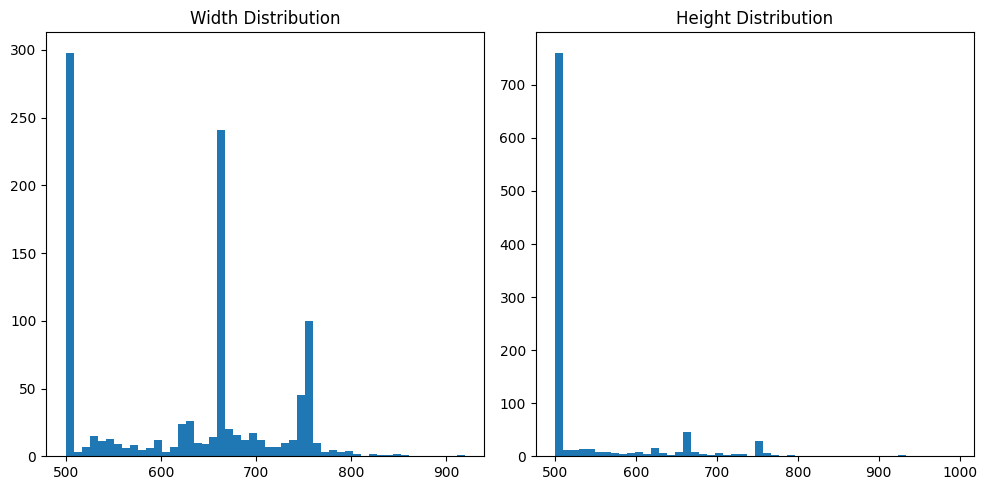

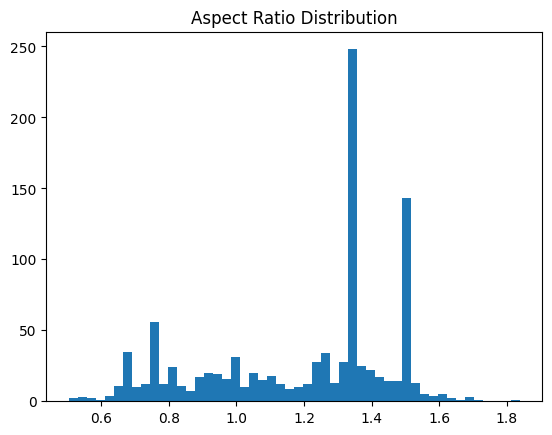

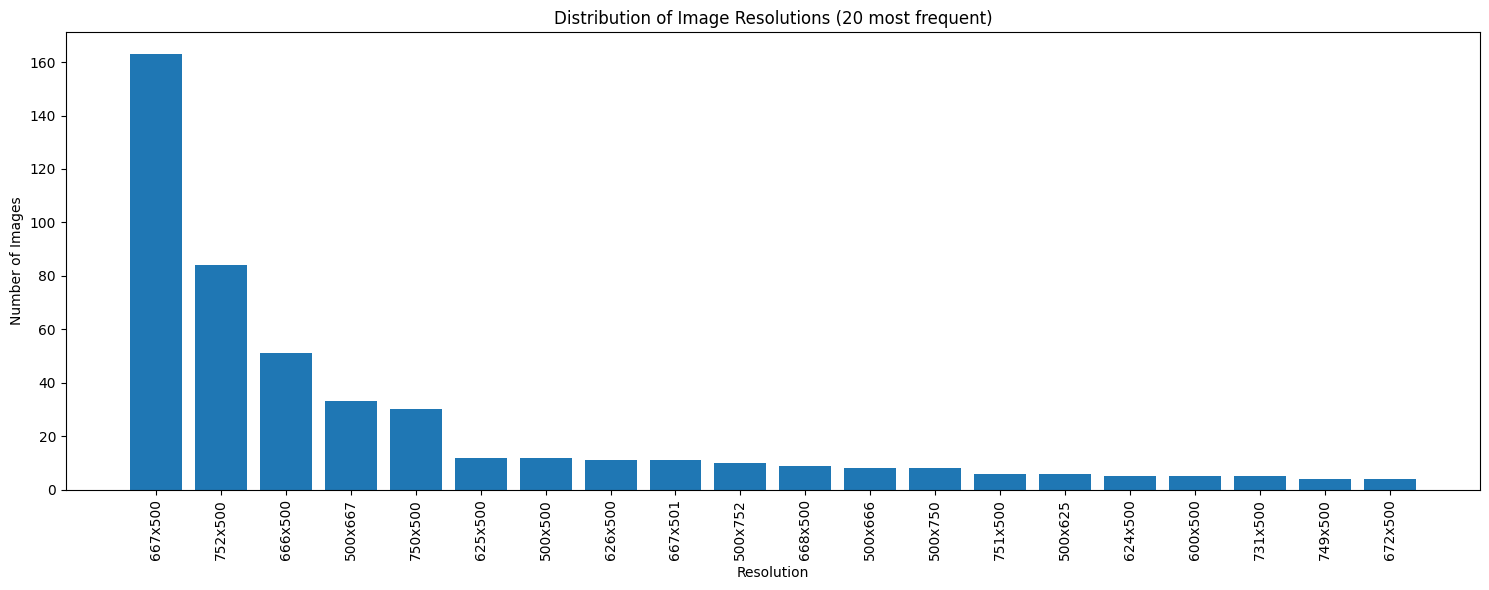

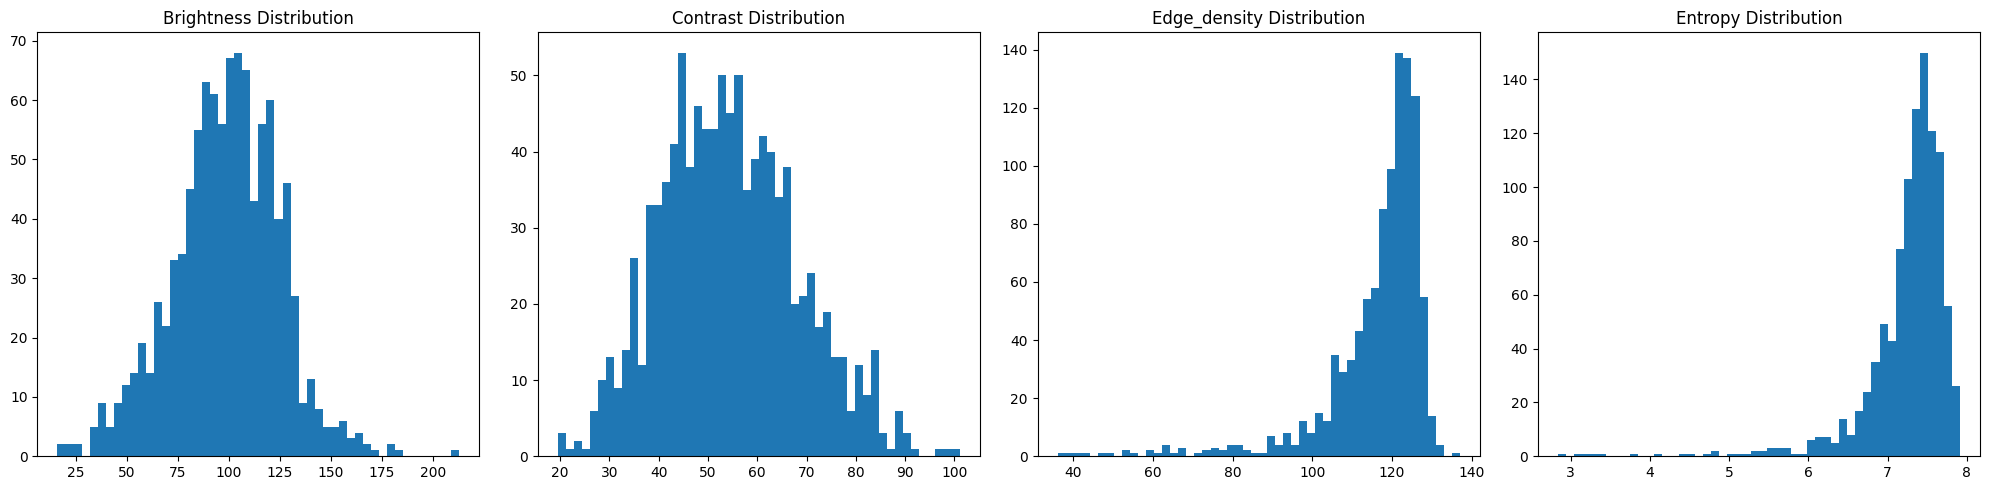

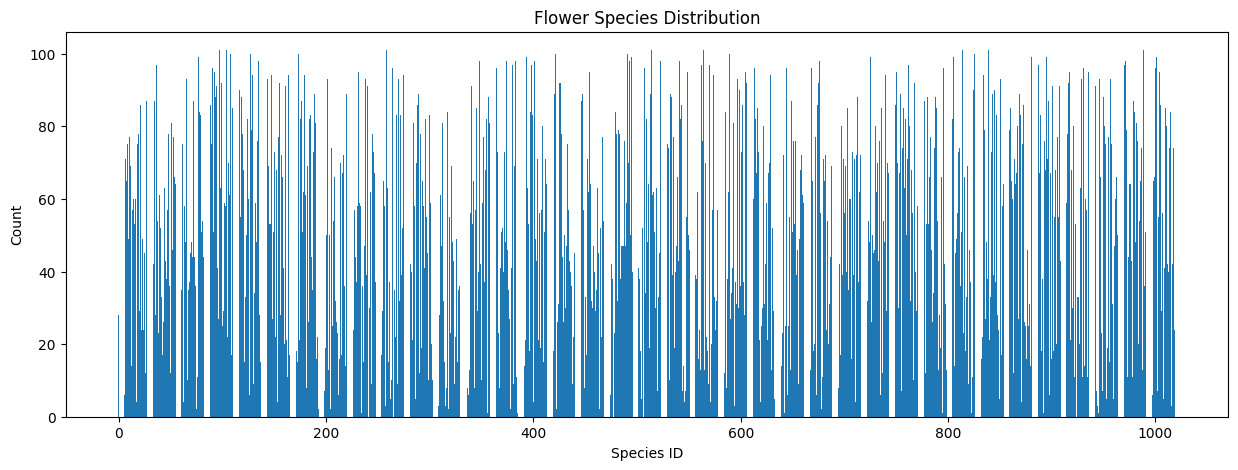

In [41]:
#Analyze Flowers102
analyze_dataset('./data', is_flowers=True)

Total images: 20000
Average size: [178. 218.]
Size std dev: [0. 0.]
Average aspect ratio: 0.8165137614678901


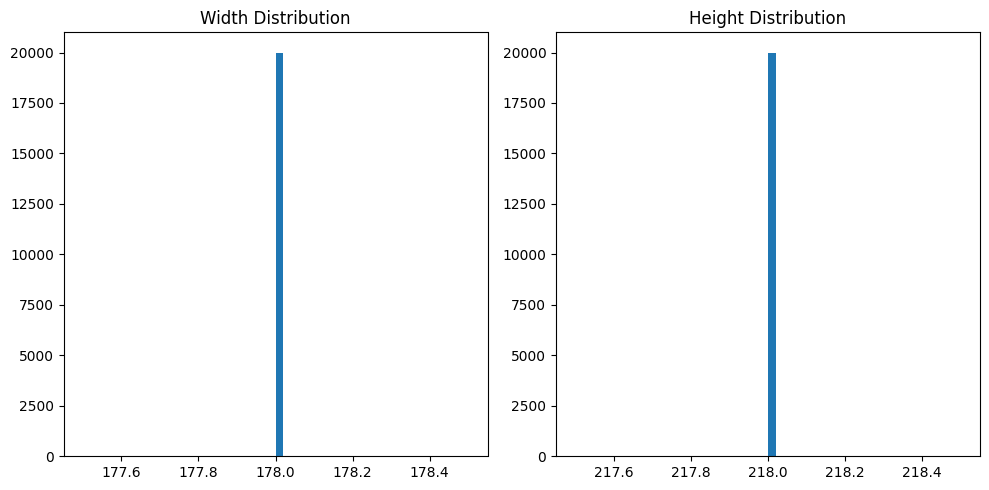

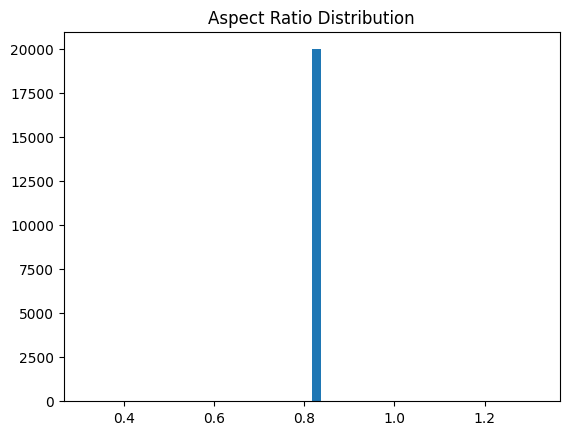

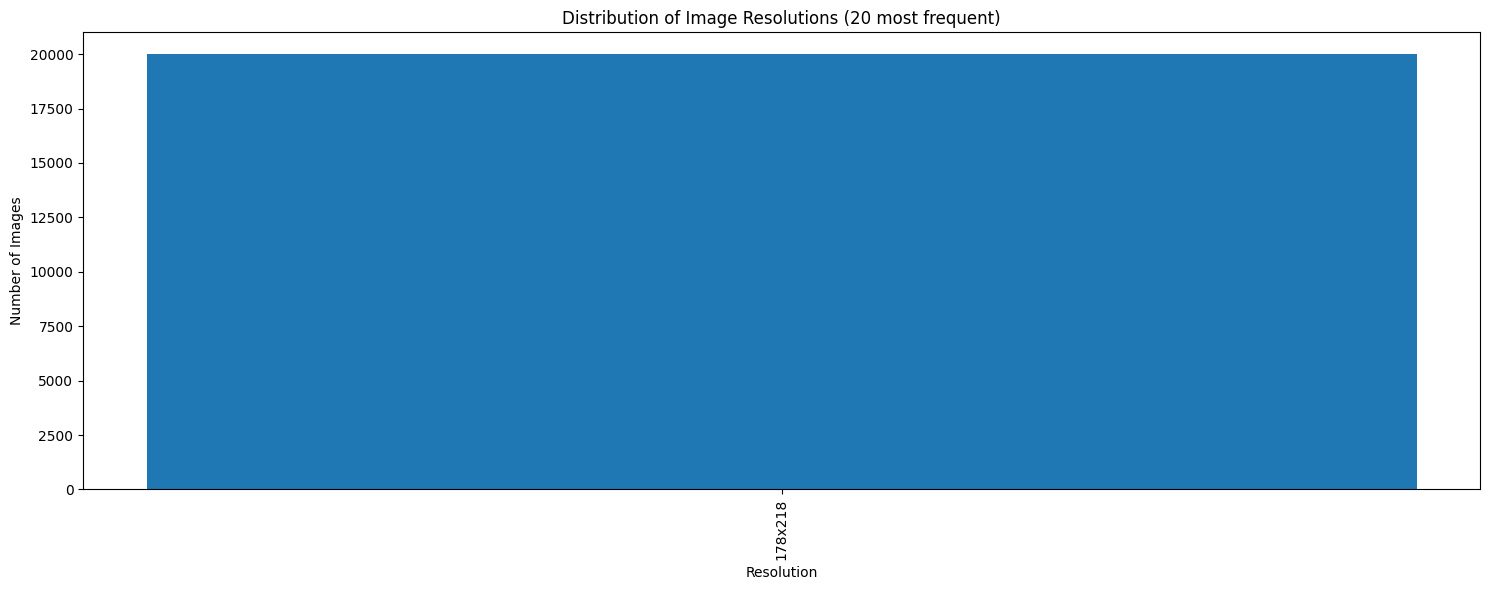

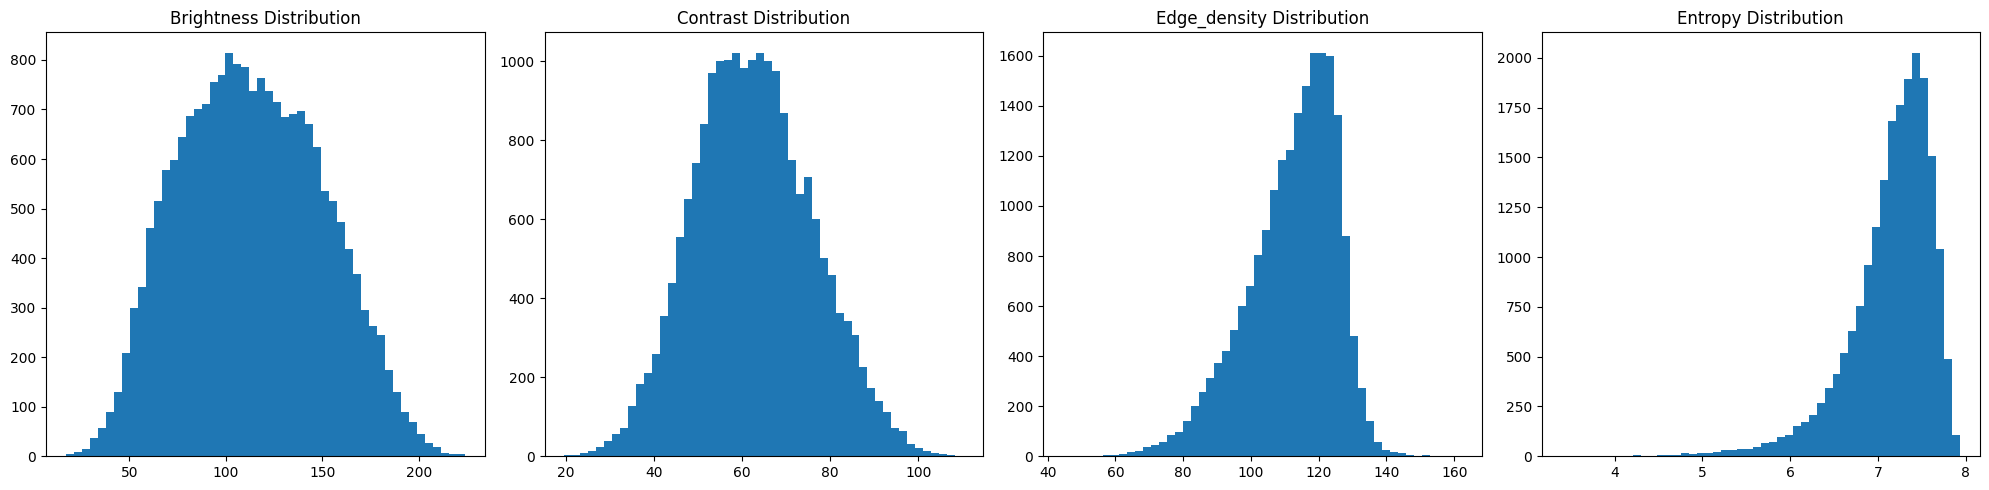

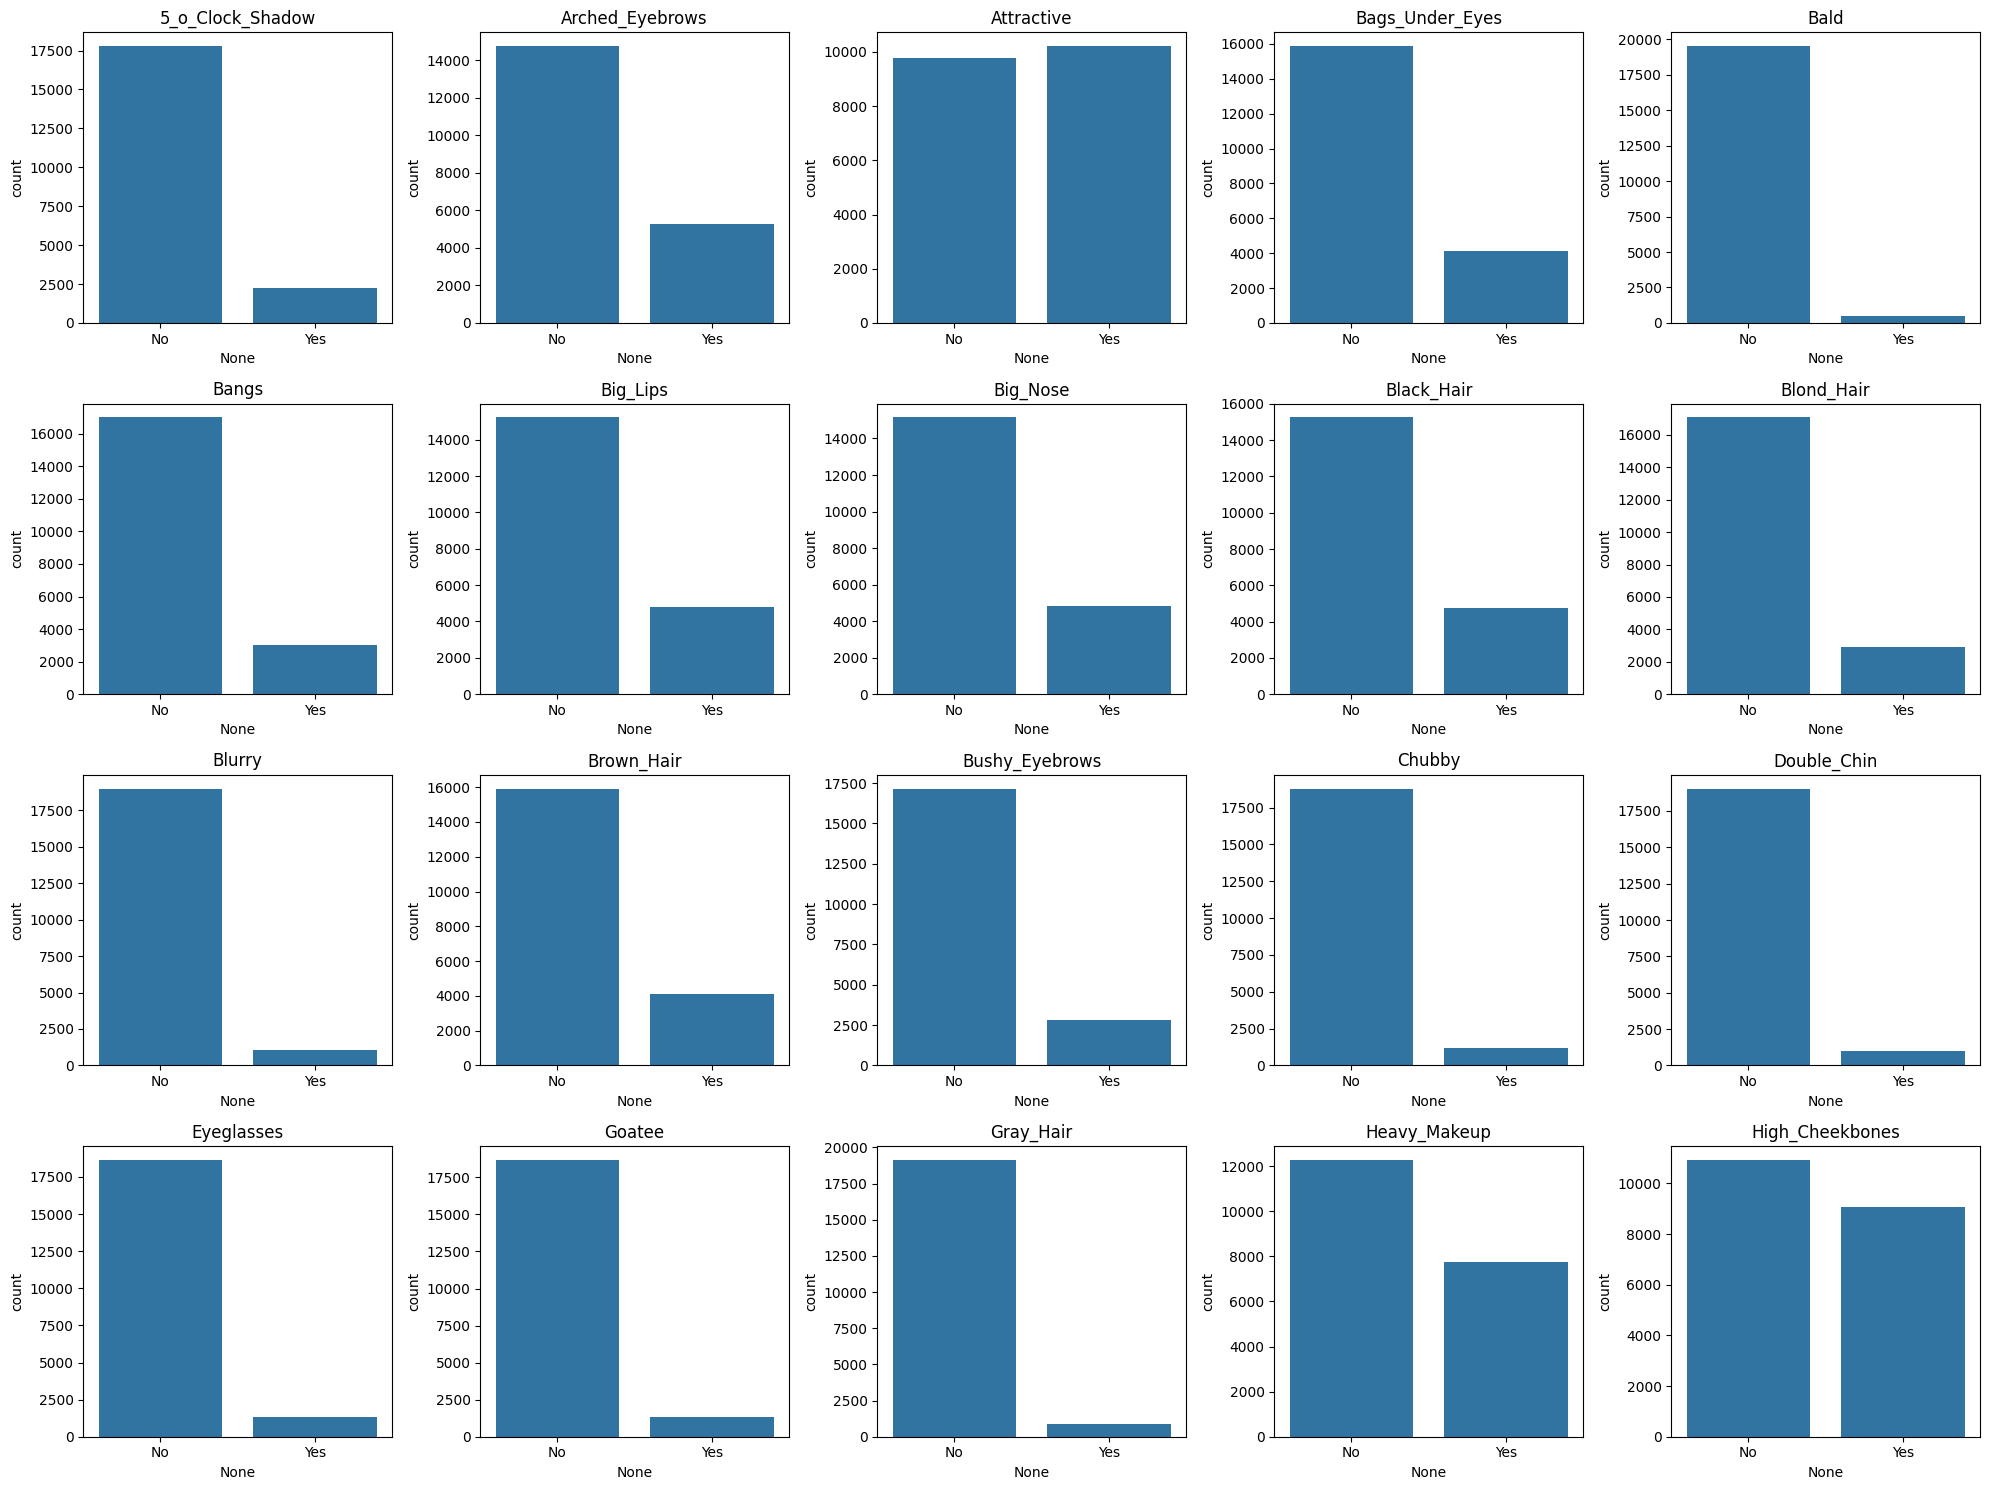

In [48]:
#Analyze CelebA
analyze_dataset("./data", is_flowers=False, sample_size=20000)

## 3. Data Cleansing and Preparation

In [4]:
def prepare_data(dataset_path, split=None, is_flowers=False, image_size=64, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if is_flowers:
        dataset = Flowers102(root=dataset_path, split=split, download=False, transform=transform)
    else:
        #dataset = CelebADataset(dataset_path, transform=transform)
        dataset = CelebA(root=dataset_path,split=split, download=False, transform=transform)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return dataloader

#def clean_data(dataloader):
#    cleaned_images = []
#    cleaned_labels = []
#
#    for batch in dataloader:
#        images, labels = batch  # Unpack the batch into images and labels
#    
#        # Apply isfinite() to the images tensor
#        mask = torch.isfinite(images).all(dim=(1, 2, 3))
#    
#        # Apply the mask to both images and labels
#        cleaned_images.append(images[mask])
#        cleaned_labels.append(labels[mask])
#    
#    return torch.cat(cleaned_images, dim=0)

def clean_data(dataloader):
    cleaned_images = []
    cleaned_labels = []

    for batch in tqdm(dataloader, desc="Cleaning data"):
        images, labels = batch  # Unpack the batch into images and labels
    
        # Apply isfinite() to the images tensor
        mask = torch.isfinite(images).all(dim=(1, 2, 3))
    
        # Apply the mask to both images and labels
        cleaned_images.append(images[mask])
        cleaned_labels.append(labels[mask])
    
    return torch.cat(cleaned_images, dim=0), torch.cat(cleaned_labels, dim=0)

#def split_data(images, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
#    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"
#    
#    dataset = torch.utils.data.TensorDataset(images, labels)
#    total_size = len(dataset)
#    train_size = int(train_ratio * total_size)
#    val_size = int(val_ratio * total_size)
#    test_size = total_size - train_size - val_size
#    
#    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#    
#    return train_dataset, val_dataset, test_dataset

In [5]:
flowers_train_loader = prepare_data("./data", split='train',  is_flowers=True)
flowers_val_loader = prepare_data("./data", split='val',  is_flowers=True)
flowers_test_loader = prepare_data("./data", split='test',  is_flowers=True)
print(type(flowers_train_loader))
print(type(flowers_val_loader))
print(type(flowers_test_loader))
cleaned_train_flowers = clean_data(flowers_train_loader)
print(f"Cleaned Flowers102 train dataset size: {cleaned_train_flowers[0].shape}")
cleaned_val_flowers = clean_data(flowers_val_loader)
print(f"Cleaned Flowers102 valid dataset size: {cleaned_val_flowers[0].shape}")
cleaned_test_flowers = clean_data(flowers_test_loader)
print(f"Cleaned Flowers102 test  dataset size: {cleaned_test_flowers[0].shape}")
torch.save(cleaned_train_flowers[0], "./prepared_datasets/train_flowers.pt")
torch.save(cleaned_train_flowers[1], "./prepared_datasets/train_flowers_labels.pt")
torch.save(cleaned_val_flowers[0], "./prepared_datasets/val_flowers.pt")
torch.save(cleaned_val_flowers[1], "./prepared_datasets/val_flowers_labels.pt")
torch.save(cleaned_test_flowers[0], "./prepared_datasets/test_flowers.pt")
torch.save(cleaned_test_flowers[1], "./prepared_datasets/test_flowers_labels.pt")

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


Cleaning data: 100%|██████████| 32/32 [00:02<00:00, 15.40it/s]


Cleaned Flowers102 train dataset size: torch.Size([1020, 3, 64, 64])


Cleaning data: 100%|██████████| 32/32 [00:02<00:00, 15.91it/s]


Cleaned Flowers102 valid dataset size: torch.Size([1020, 3, 64, 64])


Cleaning data: 100%|██████████| 193/193 [00:11<00:00, 16.56it/s]


Cleaned Flowers102 test  dataset size: torch.Size([6149, 3, 64, 64])


In [6]:
celeba_train_loader = prepare_data("./data", split='train',  is_flowers=False)
print(type(celeba_train_loader))
cleaned_train_celeba = clean_data(celeba_train_loader)
print(f"Cleaned celeba train dataset size: {cleaned_train_celeba[0].shape}")
torch.save(cleaned_train_celeba[0], "./data/prepared_datasets/train_celeba.pt")
torch.save(cleaned_train_celeba[1], "./data/prepared_datasets/train_celeba_labels.pt")

<class 'torch.utils.data.dataloader.DataLoader'>


Cleaning data: 100%|██████████| 5087/5087 [03:37<00:00, 23.43it/s]


Cleaned celeba train dataset size: torch.Size([162770, 3, 64, 64])


In [7]:
celeba_val_loader = prepare_data("./data", split='valid',  is_flowers=False)
print(type(celeba_val_loader))
cleaned_val_celeba = clean_data(celeba_val_loader)
print(f"Cleaned celeba val dataset size: {cleaned_val_celeba[0].shape}")
torch.save(cleaned_val_celeba[0], "./data/prepared_datasets/val_celeba.pt")
torch.save(cleaned_val_celeba[1], "./data/prepared_datasets/val_celeba_labels.pt")

<class 'torch.utils.data.dataloader.DataLoader'>


Cleaning data: 100%|██████████| 621/621 [00:27<00:00, 22.24it/s]


Cleaned celeba val dataset size: torch.Size([19867, 3, 64, 64])


In [8]:
celeba_test_loader = prepare_data("./data", split='test',  is_flowers=False)
print(type(celeba_test_loader))
cleaned_test_celeba = clean_data(celeba_test_loader)
print(f"Cleaned celeba test dataset size: {cleaned_test_celeba[0].shape}")
torch.save(cleaned_test_celeba[0], "./data/prepared_datasets/test_celeba.pt")
torch.save(cleaned_test_celeba[1], "./data/prepared_datasets/test_celeba_labels.pt")

<class 'torch.utils.data.dataloader.DataLoader'>


Cleaning data: 100%|██████████| 624/624 [00:28<00:00, 22.20it/s]


Cleaned celeba test dataset size: torch.Size([19962, 3, 64, 64])


## 4. Baseline model

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class VAE(nn.Module):
    def __init__(self, image_channels=3, latent_dim=128):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, 4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [18]:
def train_vae(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    def loss_function(recon_x, x, mu, log_var):
        # print("Output shape:", recon_x.shape)
        # print("Target shape:", x.shape)
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD
    
    model = model.to(device)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, data, mu, log_var)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon_batch, mu, log_var = model(data)
                val_loss += loss_function(recon_batch, data, mu, log_var).item()
        
        # Print metrics
        print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
              f'Val Loss: {val_loss/len(val_loader.dataset):.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_vae.pt')


In [19]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, batch_size=32):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader

In [20]:
# Load your saved data
train_data = torch.load("./prepared_datasets/train_flowers.pt")
train_labels = torch.load("./prepared_datasets/train_flowers_labels.pt")
val_data = torch.load("./prepared_datasets/val_flowers.pt")
val_labels = torch.load("./prepared_datasets/val_flowers_labels.pt")

In [36]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())

# Create data loaders
train_loader, val_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels)

print(train_data.min(), train_data.max())
print(val_data.min(), val_data.max())

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


In [37]:
# Initialize and train the model
model = VAE(image_channels=3, latent_dim=128)
train_vae(model, train_loader, val_loader, num_epochs=100)

Epoch 1: Train Loss: 8626.8262, Val Loss: 8549.0066
Epoch 2: Train Loss: 8253.2734, Val Loss: 7976.8250
Epoch 3: Train Loss: 7821.1896, Val Loss: 7758.9657
Epoch 4: Train Loss: 7634.8555, Val Loss: 7572.8928
Epoch 5: Train Loss: 7518.9459, Val Loss: 7516.3370
Epoch 6: Train Loss: 7462.5509, Val Loss: 7459.3353
Epoch 7: Train Loss: 7406.6879, Val Loss: 7413.7379
Epoch 8: Train Loss: 7356.2458, Val Loss: 7361.1569
Epoch 9: Train Loss: 7314.6004, Val Loss: 7318.2022
Epoch 10: Train Loss: 7264.6079, Val Loss: 7275.8162
Epoch 11: Train Loss: 7214.6724, Val Loss: 7224.9598
Epoch 12: Train Loss: 7173.6500, Val Loss: 7228.4468
Epoch 13: Train Loss: 7144.8565, Val Loss: 7160.2465
Epoch 14: Train Loss: 7105.3175, Val Loss: 7134.5229
Epoch 15: Train Loss: 7084.8064, Val Loss: 7116.2217
Epoch 16: Train Loss: 7070.6105, Val Loss: 7107.8510
Epoch 17: Train Loss: 7059.1621, Val Loss: 7096.0286
Epoch 18: Train Loss: 7051.1510, Val Loss: 7085.5740
Epoch 19: Train Loss: 7041.4174, Val Loss: 7080.6230
Ep

In [38]:
def generate_images(model, num_images=16, device='cuda'):
    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_images, 128).to(device)
        # Generate images
        generated = model.decode(z)
        return generated.cpu()

In [39]:
# Load the best model
model.load_state_dict(torch.load('best_vae.pt'))
# Generate 16 new images
generated_images = generate_images(model, num_images=16)



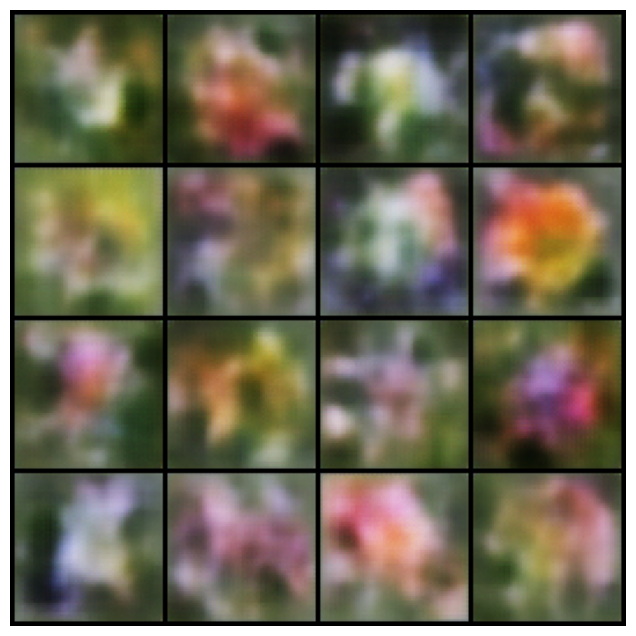

In [40]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display generated images in a grid
def plot_generated_images(images, num_images=16):
    # Arrange the images in a grid
    grid = vutils.make_grid(images, nrow=4, normalize=True, value_range=(0, 1))  # 4x4 grid for 16 images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Convert from CHW to HWC for plotting
    plt.axis('off')
    plt.show()

# Plot the generated images
plot_generated_images(generated_images)